In [673]:
import mysql.connector
from mysql.connector import errorcode
import psycopg2 as pg

import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
%matplotlib inline

In [674]:
DATABASE = 'stage'

if DATABASE == 'prod':
    config = {
      'user': 'alienbaby',
      'password': 'alienbabymoonangel',
      'host': 'intelligenttrading-aurora-production-primary-cluster.cluster-caexel1tmds5.us-east-1.rds.amazonaws.com',
      'port': '3306',
      'database': 'intelligenttrading_primary',
      'raise_on_warnings': True,
    }
    try:
      db_connection = mysql.connector.connect(**config)
    except mysql.connector.Error as err:
      if err.errno == errorcode.ER_ACCESS_DENIED_ERROR:
        print("Something is wrong with your user name or password")
      elif err.errno == errorcode.ER_BAD_DB_ERROR:
        print("Database does not exist")
      else:
        print(err)
        
elif DATABASE == 'stage':
    config = {
      'user': 'alienbaby',
      'password': 'alienbabymoonangel',
      'host': 'intelligenttrading-aurora-production-postgres-cluster.cluster-caexel1tmds5.us-east-1.rds.amazonaws.com',
      'port': '5432',
      'dbname': 'primary_postgres'
    }

    try:
      db_connection = pg.connect(**config)
    except mysql.connector.Error as err:
      if err.errno == errorcode.ER_ACCESS_DENIED_ERROR:
        print("Something is wrong with your user name or password")
      elif err.errno == errorcode.ER_BAD_DB_ERROR:
        print("Database does not exist")
      else:
        print(err)
    


In [675]:

query_eth60 = (" SELECT * FROM indicator_price WHERE transaction_currency='BTC' AND counter_currency=2 " )
df_eth60 = pd.read_sql(query_eth60, con=db_connection)

# make index a timestamp relative_strength
df_eth60['timestamp'] = pd.to_datetime(df_eth60['timestamp'], unit='s')
df_eth60.index = pd.DatetimeIndex(df_eth60.timestamp)



In [676]:
#df_eth60.tail(100)

In [689]:
# ts.resample(rule='D', how='sum', closed='left', label='left')
# https://stackoverflow.com/questions/12579150/resample-hourly-timeseries-with-certain-starting-hour

# https://stackoverflow.com/questions/38409962/pandas-trade-signal-columns
# https://stackoverflow.com/questions/28477222/python-pandas-calculate-ichimoku-chart-components/28478631


# index = pd.date_range('2013-1-1',periods=100,freq='30Min')
# data = pd.DataFrame(data=list(range(100)), columns=['value'], index=index)

# get middle point prices
price_ts = df_eth60.tail(90000).price

R_PERIOD='1H'
par_1_9 = 9
par_2_26 = 26
par_3_52 = 52
par_4_26 = 26

price_high_ts = price_ts.resample(rule=R_PERIOD).max()
price_low_ts = price_ts.resample(rule=R_PERIOD).min()
closing_price_ts = price_ts.resample(rule=R_PERIOD).last()
midpoint_price_ts = (price_high_ts + price_low_ts)/2



In [690]:
# Tenkan-sen (Conversion Line): (9-period high + 9-period low)/2))

tenkan_sen_conversion = midpoint_price_ts.rolling(window=par_1_9, center=False, min_periods=5).mean()
kijun_sen_base = midpoint_price_ts.rolling(window=par_2_26, center=False, min_periods=15).mean()

senkou_span_a_leading = ((tenkan_sen_conversion + kijun_sen_base) / 2).shift(par_2_26)

period52 = midpoint_price_ts.rolling(window=par_3_52, center=False, min_periods=25).mean()
senkou_span_b_leading = period52.shift(par_2_26)

hikou_span_lagging = closing_price_ts.shift(-par_2_26)

# combine everythin into one dataFrame

df = pd.DataFrame({
    'idx_col': price_low_ts.index,
    'low': price_low_ts,
    'high': price_high_ts, 
    'closing': closing_price_ts,
    'conversion' : tenkan_sen_conversion,
    'base' : kijun_sen_base,
    'leading_a': senkou_span_a_leading,
    'leading_b': senkou_span_b_leading,
    'lagging': hikou_span_lagging
})
df = df[['low','high', 'closing', 'conversion', 'base', 'leading_a','leading_b','lagging','idx_col']]




In [691]:
# https://stackoverflow.com/questions/38409962/pandas-trade-signal-columns

# kumo breakout up
df['closing_above_cloud'] = np.where( ((df.closing > df.leading_a) & (df.closing > df.leading_b)), 1, 0)

df['closing_cloud_breakout_up'] = \
    np.sign(df.closing - pd.concat([df.leading_a, df.leading_b], axis=1).max(axis=1)).fillna(0).diff().gt(0)
df['closing_cloud_breakout_down'] = \
    np.sign(df.closing - pd.concat([df.leading_a, df.leading_b], axis=1).max(axis=1)).fillna(0).diff().lt(0)

df['closing_cloud_breakout_up_extended'] = df['closing_cloud_breakout_up'] | df['closing_cloud_breakout_up'].shift(1) | df['closing_cloud_breakout_up'].shift(2)
df['closing_cloud_breakout_down_extended'] = df['closing_cloud_breakout_down'] | df['closing_cloud_breakout_down'].shift(1) | df['closing_cloud_breakout_down'].shift(2)

df['lagging_above_cloud'] = np.where( 
    ((df.lagging.shift(par_4_26) > df.leading_a.shift(par_4_26)) & 
     (df.lagging.shift(par_4_26) > df.leading_b.shift(par_4_26))), 
    1, 0)
df['lagging_below_cloud'] = np.where( 
    ((df.lagging.shift(par_4_26) < df.leading_a.shift(par_4_26)) & 
     (df.lagging.shift(par_4_26) < df.leading_b.shift(par_4_26))), 
    1, 0)


df['lagging_above_highest'] = np.where(df.lagging > df.high, 1, 0)
df['lagging_below_lowest'] = np.where(df.lagging < df.low, 1, 0)

df['conversion_above_base'] = np.where(df.conversion > df.base, 1, 0)
df['conversion_cross_base_down'] = np.sign(df.conversion - df.base).diff().lt(0)


df['kumo_breakout_up_rules'] = np.where(
    (df.closing_cloud_breakout_up_extended &
     df.lagging_above_cloud &
     df.lagging_above_highest & 
     df.conversion_above_base
    ) == True, 
    1, 0)

df['kumo_breakout_up_signals'] = df.kumo_breakout_up_rules.diff().gt(0)

# kumo_breakout_down



In [692]:
#df[['conversion_above_base', 'conversion_cross_base_down']].tail(30)

In [693]:
test = df[['kumo_breakout_up_signals',
    'kumo_breakout_up_rules',
    'closing_cloud_breakout_up_extended',
    'lagging_above_cloud',
    'lagging_above_highest',
    'conversion_above_base']]

test.tail(90)#[test.kumo_breakout_up_signals==True]


,kumo_breakout_up_signals,kumo_breakout_up_rules,closing_cloud_breakout_up_extended,lagging_above_cloud,lagging_above_highest,conversion_above_base
timestamp,,,,,,
2017-12-16 20:00:00,False,0,False,1,0,1
2017-12-16 21:00:00,False,0,False,1,0,1
2017-12-16 22:00:00,False,0,False,1,0,1
2017-12-16 23:00:00,False,0,False,1,0,1
2017-12-17 00:00:00,False,0,False,1,0,1
2017-12-17 01:00:00,False,0,False,1,0,1
2017-12-17 02:00:00,False,0,False,1,0,1
2017-12-17 03:00:00,False,0,False,1,0,1
2017-12-17 04:00:00,False,0,False,1,0,1


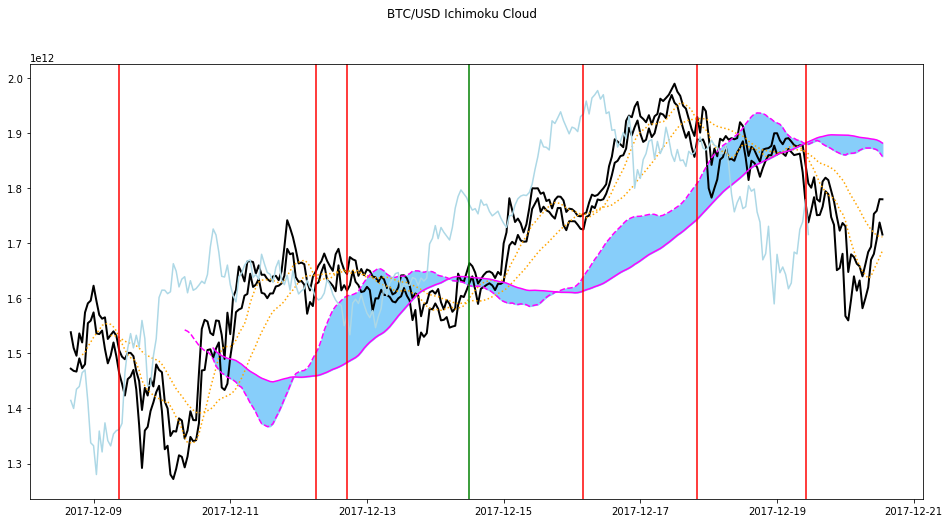

In [694]:
fig, ax1 = plt.subplots(nrows=1, ncols=1, figsize=(16,8))
fig.suptitle("BTC/USD Ichimoku Cloud")
ax1.plot(df.high, color='black', linewidth=2)
ax1.plot(df.low, color='black', linewidth=2)
ax1.plot(df.conversion, linestyle=':', color='orange')
ax1.plot(df.base, linestyle=':', color='orange')
ax1.plot(df.leading_a, linestyle='--', color='magenta')
ax1.plot(df.leading_b, linestyle='-', color='magenta')
ax1.fill_between(senkou_span_a_leading.index, df.leading_a, df.leading_b, color='lightskyblue')

ax1.plot(hikou_span_lagging, linestyle='-', color='lightblue')

# buy signal
for time_of_signal in df[df.kumo_breakout_up_signals==True].index:
    ax1.axvline(time_of_signal, color='green')

# sell signal
for time_of_signal in df[df.conversion_cross_base_down==True].index:
    ax1.axvline(time_of_signal, color='red')
  
plt.show()